Sarcasm Detection using Hierarchical Bert¶
By : Hossam Farhoud

Research Paper: https://aclanthology.org/2020.figlang-1.14.pdf

This project implements sarcasm detection using a Hierarchical BERT architecture, inspired by a research paper that combines the power of the BERT model with additional layers like BiLSTM and CNN. The aim is to classify text comments into sarcastic or non-sarcastic categories, addressing the challenge of understanding subtle language nuances.

Key highlights of the project include:

1-Data Preprocessing: Cleaning and preparing the dataset by removing unwanted characters, converting text to lowercase, and tokenizing the text using BERT tokenizer.

2-Hierarchical Architecture: Integrating BERT embeddings with advanced layers for sentence encoding, context summarization, and feature extraction.

3-Binary Classification: Leveraging the processed data and hierarchical model to classify comments with high accuracy. The model architecture incorporates:

1- BERT: For contextual word embeddings.

2- BiLSTM: To capture sequential dependencies.

3-CNN: To detect local patterns for better feature extraction.

4-Dense Layers: To make the final predictions. This implementation demonstrates the potential of combining pretrained models like BERT with additional architectural enhancements to tackle complex NLP tasks. Below is the full code for implementing this project. 🚀BertTokenizer

About Dataset
Context
This dataset contains 1.3 million Sarcastic comments from the Internet commentary website Reddit. The dataset was generated by scraping comments from Reddit (not by me :) containing the \s ( sarcasm) tag. This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content.

Content
Data has balanced and imbalanced (i.e true distribution) versions. (True ratio is about 1:100). The
corpus has 1.3 million sarcastic statements, along with what they responded to as well as many non-sarcastic comments from the same source.

Labelled comments are in the train-balanced-sarcasm.csv file.

Acknowledgements
The data was gathered by: Mikhail Khodak and Nikunj Saunshi and Kiran Vodrahalli for their article "A Large Self-Annotated Corpus for Sarcasm". The data is hosted here.

#1. DATA LOADING AND PREPROCESSING

In [2]:
import zipfile  # For handling zip files
import pandas as pd  # For data manipulation
from transformers import BertTokenizer, TFBertModel  # For BERT tokenization and model
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
import tensorflow as tf  # For building and training deep learning models
import warnings  # For suppressing warnings
warnings.filterwarnings('ignore')

In [ ]:
# # Setting up Kaggle to access the dataset
# !mkdir -p ~/.kaggle  # Creating Kaggle directory
# !cp kaggle.json ~/.kaggle  # Copying Kaggle API credentials

# # Downloading the Sarcasm dataset from Kaggle
# !kaggle datasets download -d danofer/sarcasm

# # Extracting the zip contents
# zip_ref = zipfile.ZipFile('/content/sarcasm.zip')  # Opening the zip file
# zip_ref.extractall('/content')  # Extracting the contents
# zip_ref.close()  # Closing the zip file

In [3]:
# Loading the dataset into a DataFrame
df = pd.read_csv('train-balanced-sarcasm.csv')  # Reading the sarcasm dataset
df.head() 

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
# Checking the shape of the dataset
df.shape  # Outputting the dimensions of the dataset

(1010826, 10)

In [5]:
# Limiting the dataset to 10,000 rows and selecting relevant columns
df = df[:10000]  # Keeping only the first 10,000 rows
df = df[['label', 'comment']]  # Selecting the 'label' (target) and 'comment' (text input) columns
df.head()  # Displaying the first few rows of the updated DataFrame

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [6]:
# Checking the updated shape
df.shape  # Outputting the new dimensions of the dataset

(10000, 2)

In [7]:
# Checking for missing values in the dataset
df.isna().sum()  # Summing up the number of missing values in each column

label      0
comment    1
dtype: int64

In [8]:
# Dropping rows with missing values
df.dropna(inplace=True)  # Removing rows with NaN values
df.isna().sum()  # Verifying that there are no missing values

label      0
comment    0
dtype: int64

In [9]:
# Removing unwanted numerals and symbols from the 'comment' column
df['comment'] = df['comment'].str.replace(r'[^a-zA-Z\\s]', '', regex=True)  # Keeping only alphabets and spaces

In [10]:
# Converting text in the 'comment' column to lowercase
def lowercase(text):  # Defining a function for converting text to lowercase
    return text.lower()

df['comment'] = df['comment'].apply(lowercase)  # Applying the function to the 'comment' column

df.head()  # Displaying the cleaned dataset

,label,comment
0,0,ncandnh
1,0,youdoknowwestteamsplayagainstwestteamsmorethan...
2,0,theywereunderdogsearliertodaybutsincegronksann...
3,0,thismemeisntfunnynoneofthenewyorkniggaonesare
4,0,icoulduseoneofthosetools


#2. TOKENIZATION

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
def tokenize_data(text, max_length=100):
    return tokenizer(
        text.tolist(),  # Converting text to a list
        max_length=max_length,  # Setting maximum token length
        truncation=True,  # Truncating tokens longer than max_length
        padding='max_length',  # Padding tokens to max_length
        return_tensors='np'  # Returning tokens as NumPy arrays
    )

In [13]:
# Tokenizing the comments in the dataset
tokenized_data = tokenize_data(df['comment'])

tokenized_data  # Displaying the tokenized data

{'input_ids': array([[  101, 13316,  5685, ...,     0,     0,     0],
       [  101,  2017,  3527, ...,     0,     0,     0],
       [  101,  2027, 13777, ...,     0,     0,     0],
       ...,
       [  101,  5095, 15864, ...,     0,     0,     0],
       [  101, 29420,  2015, ...,     0,     0,     0],
       [  101,  2016,  3270, ...,     0,     0,     0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}

#3. TRAIN_TEST_SPLIT

In [14]:
# Separating features and labels
X = tokenized_data['input_ids']  # Input tokens
y = df['label']  # Target labels

In [15]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train.shape, X_test.shape  # Displaying the shapes of training and testing sets

((7999, 100), (2000, 100))

#4. BUILDING THE MODEL ACCORDING TO THE PROPOSED ARCHITECTURE

In [21]:
# Defining the Hierarchical BERT model
class HierarchicalBERT(tf.keras.Model):
    def __init__(self, bert_model, lstm_units, cnn_filters, dense_units):
        super(HierarchicalBERT, self).__init__()
        self.bert = bert_model  # Pretrained BERT model

        # Sentence Encoding Layer
        self.dense_sentence = tf.keras.layers.Dense(768, activation='relu')

        # Context Summarization Layer
        self.mean_pooling = tf.keras.layers.GlobalAveragePooling1D()

        # Context Encoder Layer
        self.bilstm_encoder = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm_units, return_sequences=True)
        )

        # CNN Layer
        self.conv = tf.keras.layers.Conv1D(cnn_filters, 2, activation='relu')
        self.pool = tf.keras.layers.GlobalMaxPooling1D()

        # Fully Connected Layer
        self.dense_fc = tf.keras.layers.Dense(dense_units, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification

    def call(self, inputs):
        # BERT Embeddings
        bert_output = self.bert(inputs)[0]

        # Sentence Encoding Layer
        sentence_encoded = self.dense_sentence(bert_output)

        # Context Summarization Layer
        context_summarized = self.mean_pooling(sentence_encoded)

        # Expand dimensions for LSTM input
        context_summarized = tf.expand_dims(context_summarized, 1)

        # Context Encoder Layer
        context_encoded = self.bilstm_encoder(context_summarized)

        # Squeeze dimensions for CNN input
        context_encoded_squeezed = tf.squeeze(context_encoded, axis=1)

        # Expand dimensions for CNN input
        context_encoded_expanded = tf.expand_dims(context_encoded_squeezed, axis=-1)

        # CNN Layer
        conv_output = self.conv(context_encoded_expanded)
        pooled_output = self.pool(conv_output)

        # Fully Connected Layer
        dense_output = self.dense_fc(pooled_output)

        # Output Layer
        final_output = self.output_layer(dense_output)
        return final_output

In [22]:
# Loading the pretrained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [23]:
# Defining the Hierarchical BERT model
model = HierarchicalBERT(bert_model, lstm_units=128, cnn_filters=64, dense_units=32)

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# Training the model
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5


250/250 [==============================] - 1063s 4s/step - loss: 0.6629 - accuracy: 0.6272
Epoch 2/5
250/250 [==============================] - 1168s 5s/step - loss: 0.6613 - accuracy: 0.6268
Epoch 3/5
250/250 [==============================] - 1162s 5s/step - loss: 0.6608 - accuracy: 0.6268
Epoch 4/5
250/250 [==============================] - 1433s 6s/step - loss: 0.6611 - accuracy: 0.6268
Epoch 5/5
250/250 [==============================] - 1116s 4s/step - loss: 0.6611 - accuracy: 0.6268


In [26]:
# Evaluating the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy * 100}%')  # Printing the model accuracy

63/63 [==============================] - 87s 1s/step - loss: 0.6551 - accuracy: 0.6375
Model Accuracy: 63.749998807907104%


63/63 [==============================] - 93s 1s/step


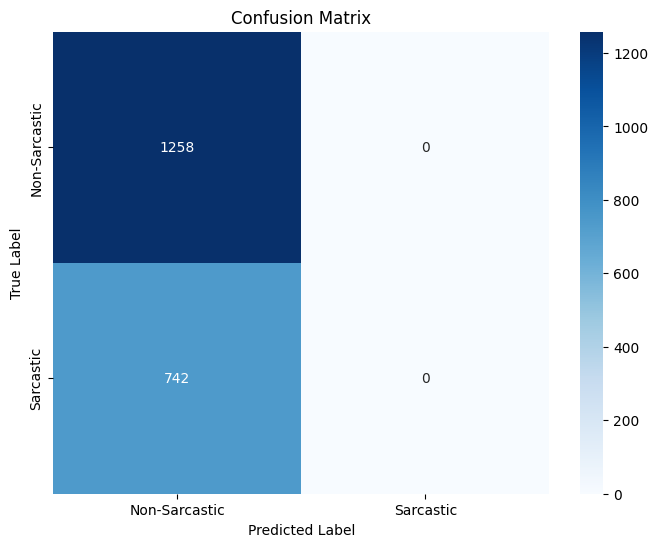

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the model and test data (X_test, y_test) already defined
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



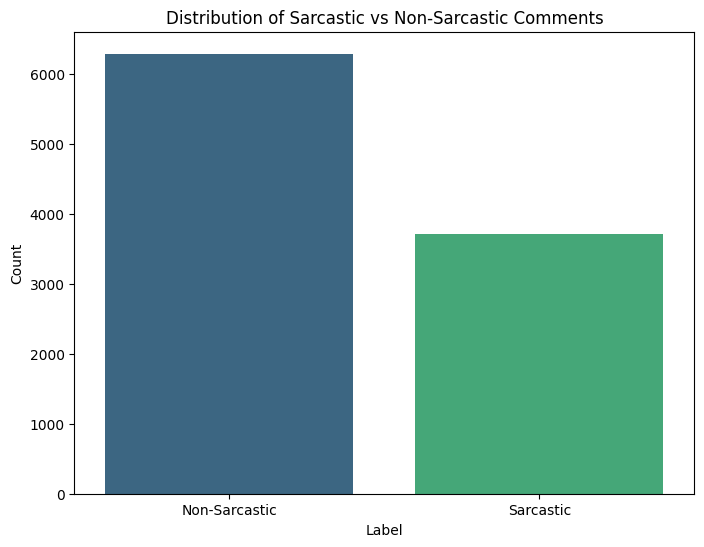

In [34]:
# Count the number of sarcastic and non-sarcastic comments
label_counts = df['label'].value_counts()

# Creating a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Sarcastic vs Non-Sarcastic Comments')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'])
plt.show()


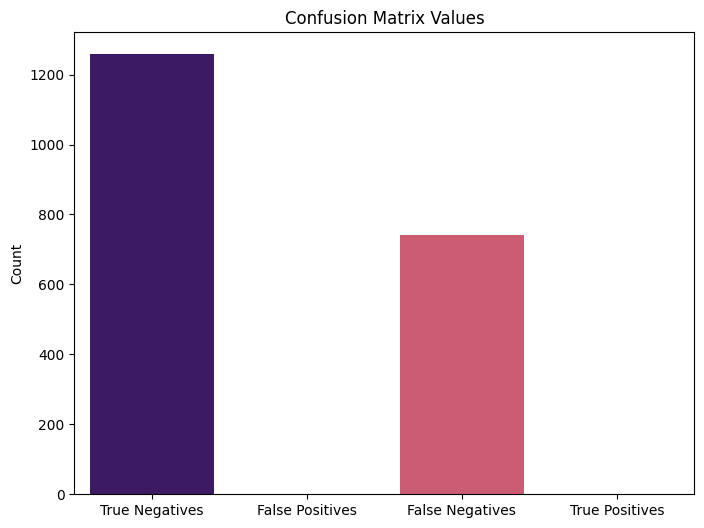

In [36]:
# Assuming 'cm' is your confusion matrix
true_negatives = cm[0][0]
false_positives = cm[0][1]
false_negatives = cm[1][0]
true_positives = cm[1][1]

# Creating a bar plot
labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
values = [true_negatives, false_positives, false_negatives, true_positives]

plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=values, palette='magma')
plt.title('Confusion Matrix Values')
plt.ylabel('Count')
plt.show()
